## Useful imports

In [1]:
import pandas as pd
import numpy as np
import json
import re
import time
import datetime as dt
import matplotlib.pyplot as plt
import ast
import operator
from sklearn import linear_model, model_selection, feature_selection
from selenium import webdriver
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager

In [2]:

def get_features(row):
    """ access the wanted fields from one row of data """
    try:
        location_id = row["location"]["id"]
    except:
        location_id = None
    try:
        location_name = row["location"]["name"]
    except:
        location_name = None
    try:
        tags = row["tags"]
    except:
        tags = []
    timestamp = dt.datetime.fromtimestamp(row["taken_at_timestamp"])
    

    try:
        address_str = json.loads(row["location"]["address_json"])
        address = address_str["street_address"]
        zip_code = address_str["zip_code"]
        city_name = address_str["city_name"]
        region_name = address_str["region_name"]
    except:
        address_str = []
        address = []
        zip_code = []
        city_name = []
        region_name = []


    return [location_id, location_name, address, zip_code, city_name, region_name, tags, timestamp]

In [3]:
filepath = '100k.json'

start = time.time()

with open(filepath, encoding = 'utf8') as f:
    data = json.load(f)
data = data["GraphImages"]

end = time.time()
start = time.time()

df = pd.DataFrame(list(map(get_features, data)),
    columns = ["location_id", "location_name", "address", "zip_code", "city_name", "region_name", "tags", "timestamp"])

end = time.time()

## Extract most used tags :

In [16]:
def get_top_tags(df):
    tag_counts = {}
    for tags in df.tags.values:
        if(tags):
            for tag in ast.literal_eval(str(tags)):
                if tag in tag_counts:
                    tag_counts[tag] += 1
                else:
                    tag_counts[tag] = 1
    tag_counts = sorted(tag_counts.items(), key=operator.itemgetter(1), reverse=True)
    tag_counts = map(lambda row: row[0], tag_counts)
    return list(tag_counts)

In [17]:
def getRankTag(tag,tagsList):
    return tagsList.index(tag)+1
print(type(getRankTag("nature",tag_counts)))

<class 'int'>


## Get the number of posts for each tag in the frequent tags list and also the frequency of posting with that tag :

In [27]:
def nbPosts_freq(taglist):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    tag_df  = pd.DataFrame(columns = ['Hashtag', 'Number of Posts', 'Posting Freq (mins)'])
    for tag in taglist:

        driver.get('https://www.instagram.com/explore/tags/'+str(tag))
        soup = BeautifulSoup(driver.page_source,"lxml")

        # Extract current hashtag name
        tagname = tag
        # Extract total number of posts in this hashtag
        # NOTE: Class name may change in the website code
        # Get the latest class name by inspecting web code
        if(soup.find('span', {'class': 'g47SY'})):
            nposts = soup.find('span', {'class': 'g47SY'}).text

            # Extract all post links from 'explore tags' page
            # Needed to extract post frequency of recent posts
            myli = []
            for a in soup.find_all('a', href=True):
                myli.append(a['href'])
            # Keep link of only 1st and 9th most recent post
            newmyli = [x for x in myli if x.startswith('/p/')]
            #del newmyli[:10]
            #del newmyli[10:]
            #del newmyli[1:9]
            newmyli =[newmyli[-1], newmyli[0]]
            timediff = []
            # Extract the posting time of 1st and 9th most recent post for a tag
            for j in range(len(newmyli)):
                driver.get('https://www.instagram.com'+str(newmyli[j]))
                soup = BeautifulSoup(driver.page_source,"lxml")

                for i in soup.findAll('time'):
                    if i.has_attr('datetime'):
                        timediff.append(i['datetime'])
                        #print(i['datetime'])

            # Calculate time difference between posts
            # For obtaining posting frequency
            datetimeFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
            diff = dt.datetime.strptime(timediff[0], datetimeFormat)\
                - dt.datetime.strptime(timediff[1], datetimeFormat)
            #print(dt.datetime.strptime(timediff[0], datetimeFormat),dt.datetime.strptime(timediff[1], datetimeFormat))
            pfreq= int(diff.total_seconds()/(9*60))
            if(pfreq==0):
                pfreq="Posting frequency very high (less than 1 min)"
            print(pfreq)
            # Add hashtag info to dataframe
            tag_df.loc[len(tag_df)] = [tagname, nposts, pfreq]
    driver.quit()
    return tag_df
nbPosts_freq_perTag=nbPosts_freq(['wwwwwwwwwww'])
print(nbPosts_freq_perTag)

[WDM] - Current google-chrome version is 85.0.4183
[WDM] - Get LATEST driver version for 85.0.4183


[WDM] - Driver [C:\Users\manal\.wdm\drivers\chromedriver\win32\85.0.4183.87\chromedriver.exe] found in cache


Posting frequency very high (less than 1 min)
       Hashtag Number of Posts                            Posting Freq (mins)
0  wwwwwwwwwww             374  Posting frequency very high (less than 1 min)


## Get the months where a tag is most used :

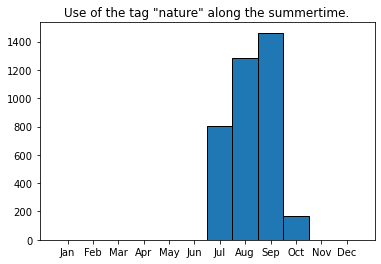

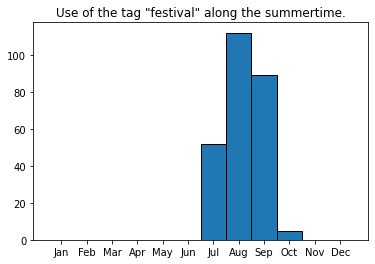

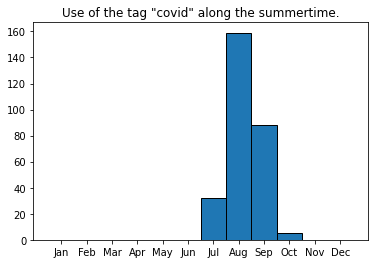

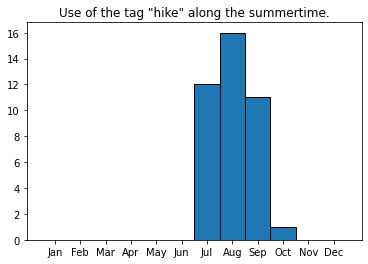

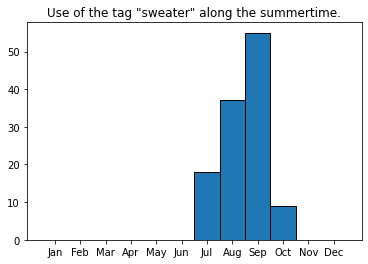

In [6]:
def findMonthsForTag(df,tag):
    times_df  = pd.DataFrame(columns = ['Tag', 'Timestamps'])
    for ind in df.index: 
        if(df['tags'][ind]):
            if(tag in str(df.iloc[ind][6])):
                temp=pd.DataFrame([[tag,df.iloc[ind][7].strftime('%#m')]], columns= ['Tag', 'Timestamps'])
                times_df=times_df.append(temp,ignore_index = True)
    times_df=(times_df.groupby('Tag')['Timestamps']
       .apply(lambda x: ','.join(map(str, x)))
       .reset_index())
    return times_df
def tagTimestamps(interestingTag):
    res=findMonthsForTag(df,interestingTag)
    if(res.empty==False):
        months = list(map(int, (res['Timestamps'].values)[0].split(",")))
        fig, ax = plt.subplots()
        bins = np.arange(1,14)
        ax.hist(months, bins = bins, edgecolor="k", align='left')
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels([dt.date(1900,i,1).strftime('%b') for i in bins[:-1]] )
        title='Use of the tag "'+interestingTag+ '" along the summertime.'
        plt.title(title)
        plt.show()
    else:
        print("Tag not used.")
        
tagTimestamps("nature")
tagTimestamps("festival")
tagTimestamps("covid")
tagTimestamps("hike")
tagTimestamps("sweater")